# MSAS Cycling Cell Feature + Label Walkthrough

This notebook demonstrates how a single **cycling-aging** MSAS cell produces its features and labels.
It walks through the discharge curves, normalization steps, and a simple temperature segmentation example.

Assumptions:
- You have run MSAS preprocessing to `data/processed/MSAS`.
- You have the `batteryml` package importable in this environment.
- This notebook uses the current EFC-aligned feature and label implementations.

In [16]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from batteryml.data.battery_data import BatteryData
from batteryml.feature.efc_normalized_voltage_capacity_matrix import (
    EFCNormalizedVoltageCapacityMatrixFeatureExtractor,
)
from batteryml.label.soh_efc import SOHAtEFCLabelAnnotator

%matplotlib inline

## 1) Select one cycling-aging cell (EFC >= 600)

In [17]:
processed_dir = Path("data/processed/MSAS")
if not processed_dir.exists():
    raise FileNotFoundError("Missing data/processed/MSAS. Run MSAS preprocessing first.")

target_cell_id = None  # Set to explicit pkl filename (without .pkl) if desired.
allowed_tags = {"ET_T23", "CU", "exCU", "AT_T23"}

def cycle_meta(cycle):
    meta = getattr(cycle, "additional_data", {}) or {}
    return meta.get("msas_efc"), meta.get("msas_tag")

def cell_max_efc(cell):
    efcs = [cycle_meta(c)[0] for c in (cell.cycle_data or [])]
    efcs = [float(e) for e in efcs if e is not None and np.isfinite(e)]
    return max(efcs) if efcs else 0.0

cell = None
if target_cell_id:
    path = processed_dir / f"{target_cell_id}.pkl"
    cell = BatteryData.load(path)
else:
    for path in sorted(processed_dir.glob("*.pkl")):
        candidate = BatteryData.load(path)
        if cell_max_efc(candidate) >= 600:
            cell = candidate
            break

if cell is None:
    raise RuntimeError("No cell with EFC >= 600 found. Set target_cell_id manually.")

print("cell_id:", cell.cell_id)
print("max_efc:", cell_max_efc(cell))

cell_id: MSAS_S1_TP_z01_01
max_efc: 3051.763634593269


## 2) Check-up table (EFC + tag + Q_end)

In [18]:
rows = []
for c in (cell.cycle_data or []):
    efc, tag = cycle_meta(c)
    if tag not in allowed_tags:
        continue
    q = np.asarray(c.discharge_capacity_in_Ah or [], dtype=float)
    q_end = float(np.nanmax(q)) if q.size else np.nan
    rows.append({"efc": efc, "tag": tag, "q_end": q_end, "n_points": len(q)})

df = pd.DataFrame(rows).sort_values("efc").reset_index(drop=True)
df.head(10)

,efc,tag,q_end,n_points
0,0.000000,ET_T23,4.767439,381
1,65.643731,CU,4.766094,376
2,130.986120,CU,4.742568,373
3,196.274869,exCU,4.723737,372
4,326.940309,CU,4.691098,370
5,446.686762,CU,4.675395,367
6,557.822726,CU,4.658208,366
7,818.018560,CU,4.623336,363
8,1068.739687,CU,4.594892,361
9,1319.460196,exCU,4.568930,359


## 3) Helper functions for curves and EFC selection

In [19]:
def get_qv(cycle):
    v = np.asarray(cycle.voltage_in_V or [], dtype=float)
    q = np.asarray(cycle.discharge_capacity_in_Ah or [], dtype=float)
    if v.size == 0 or q.size == 0 or v.size != q.size:
        return None, None
    dq = np.diff(q, prepend=q[0])
    mask = dq > 1e-9
    if mask.sum() >= 2:
        v, q = v[mask], q[mask]
    return v, q

def interp_q_on_v(v, q, grid_v):
    order = np.argsort(v)
    v = v[order]
    q = q[order]
    v_unique, inv = np.unique(v, return_inverse=True)
    q_sum = np.bincount(inv, weights=q)
    counts = np.bincount(inv)
    q_unique = q_sum / np.clip(counts, 1, None)
    out = np.interp(grid_v, v_unique, q_unique)
    out[(grid_v < v_unique[0]) | (grid_v > v_unique[-1])] = np.nan
    return out

def scale_q_to_unit_interval(v, q, min_v, max_v):
    v = np.asarray(v, dtype=float)
    q = np.asarray(q, dtype=float)
    mask = (np.isfinite(v) & np.isfinite(q) & (v >= min_v) & (v <= max_v))
    if mask.sum() < 2:
        return np.full_like(q, np.nan, dtype=float)
    q_min = float(np.nanmin(q[mask]))
    q_max = float(np.nanmax(q[mask]))
    if not np.isfinite(q_min) or not np.isfinite(q_max) or q_max <= q_min:
        return np.full_like(q, np.nan, dtype=float)
    return (q - q_min) / (q_max - q_min)

def pick_cycle_by_efc(cycles, target_efc):
    best = None
    best_err = None
    for c in cycles:
        efc, tag = cycle_meta(c)
        if tag not in allowed_tags:
            continue
        if efc is None or not np.isfinite(efc):
            continue
        err = abs(float(efc) - float(target_efc))
        if best is None or err < best_err:
            best = c
            best_err = err
    return best

## 4) Q(V) curves, Q_norm, and self-normalized Q

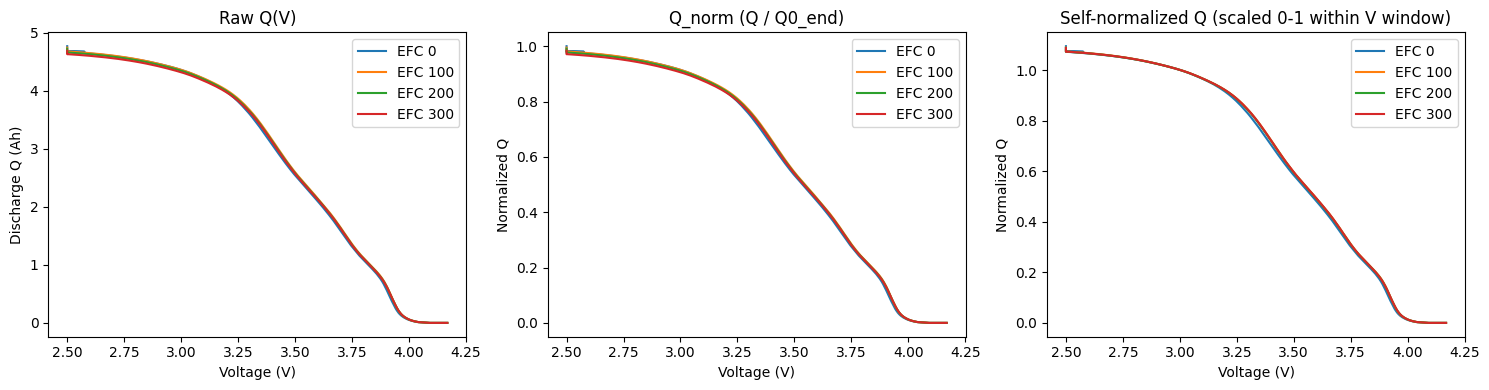

In [20]:
checkpoints = [0.0, 100.0, 200.0, 300.0]
grid_v = np.linspace(3, 4.15, 256)
grid_min_v, grid_max_v = float(grid_v.min()), float(grid_v.max())

cycles = cell.cycle_data or []
baseline = pick_cycle_by_efc(cycles, 0.0)
if baseline is None:
    raise RuntimeError("No baseline cycle found at EFC~0.")

base_v, base_q = get_qv(baseline)
q0_end = float(np.nanmax(base_q))
base_qret = base_q / q0_end
base_qshape = scale_q_to_unit_interval(base_v, base_q, grid_min_v, grid_max_v)

curves = {}
for efc in checkpoints:
    c = pick_cycle_by_efc(cycles, efc)
    if c is None:
        continue
    v, q = get_qv(c)
    q_end = float(np.nanmax(q))
    curves[efc] = {
        "v": v,
        "q": q,
        "qret": q / q0_end,
        "qshape": scale_q_to_unit_interval(v, q, grid_min_v, grid_max_v),
        "q_end": q_end,
    }

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

for efc, data in curves.items():
    axes[0].plot(data["v"], data["q"], label=f"EFC {efc:.0f}")
axes[0].set_title("Raw Q(V)")
axes[0].set_xlabel("Voltage (V)")
axes[0].set_ylabel("Discharge Q (Ah)")
axes[0].legend()

for efc, data in curves.items():
    axes[1].plot(data["v"], data["qret"], label=f"EFC {efc:.0f}")
axes[1].set_title("Q_norm (Q / Q0_end)")
axes[1].set_xlabel("Voltage (V)")
axes[1].set_ylabel("Normalized Q")
axes[1].legend()

for efc, data in curves.items():
    axes[2].plot(data["v"], data["qshape"], label=f"EFC {efc:.0f}")
axes[2].set_title("Self-normalized Q (scaled 0-1 within V window)")
axes[2].set_xlabel("Voltage (V)")
axes[2].set_ylabel("Normalized Q")
axes[2].legend()

plt.tight_layout()

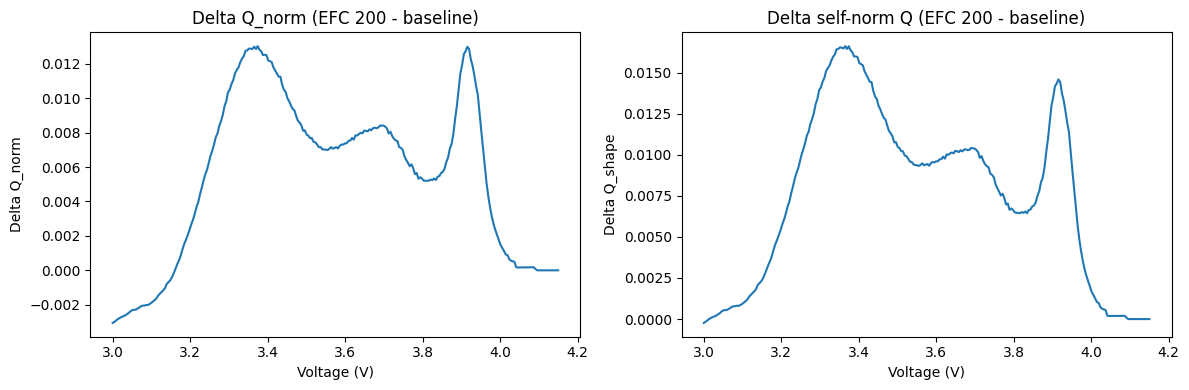

In [21]:
# Delta curves for a single checkpoint (example: EFC 200 vs baseline)
target_efc = 200.0
target_cycle = pick_cycle_by_efc(cycles, target_efc)
if target_cycle is None:
    raise RuntimeError("No cycle near EFC 200 found. Adjust target_efc.")

tv, tq = get_qv(target_cycle)
tq_ret = tq / q0_end
tq_shape = scale_q_to_unit_interval(tv, tq, grid_min_v, grid_max_v)

base_qret_lin = interp_q_on_v(base_v, base_qret, grid_v)
base_qshape_lin = interp_q_on_v(base_v, base_qshape, grid_v)
tq_ret_lin = interp_q_on_v(tv, tq_ret, grid_v)
tq_shape_lin = interp_q_on_v(tv, tq_shape, grid_v)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(grid_v, tq_ret_lin - base_qret_lin)
axes[0].set_title("Delta Q_norm (EFC 200 - baseline)")
axes[0].set_xlabel("Voltage (V)")
axes[0].set_ylabel("Delta Q_norm")

axes[1].plot(grid_v, tq_shape_lin - base_qshape_lin)
axes[1].set_title("Delta self-norm Q (EFC 200 - baseline)")
axes[1].set_xlabel("Voltage (V)")
axes[1].set_ylabel("Delta Q_shape")

plt.tight_layout()

## 5) Feature vector layout (current implementation)

In [22]:
include_cv = False  # set True to include CV tail in Q
cc_current_fraction = 0.98
cv_voltage_window_in_V = 0.05

extractor = EFCNormalizedVoltageCapacityMatrixFeatureExtractor(
    interp_dim=256,
    baseline_efc=0.0,
    efc_checkpoints=[100.0, 200.0, 300.0],
    min_voltage_in_V=2.8,
    max_voltage_in_V=4.15,
    max_abs_efc_error=400.0,
    allowed_tags=["ET_T23", "CU", "exCU", "AT_T23"],
    append_soh_scalar=True,
    include_shape_delta=True,
    include_cv=include_cv,
    cc_current_fraction=cc_current_fraction,
    cv_voltage_window_in_V=cv_voltage_window_in_V,
)

feature = extractor.process_cell(cell)
print("feature shape:", tuple(feature.shape))
print("feature head:", feature[:10].tolist())
print("feature tail:", feature[-10:].tolist())

feature shape: (1539,)
feature head: [0.0007830231334082782, 0.0007512364536523819, 0.0007194497738964856, 0.0007073523593135178, 0.0006831929204054177, 0.0006408350891433656, 0.0005984772578813136, 0.0006023641326464713, 0.0005790347931906581, 0.0005557054537348449]
feature tail: [3.6270929371085003e-08, 3.246000446210928e-08, 2.864907955313356e-08, 2.483815464415784e-08, 2.1027231511538957e-08, 1.7216306602563236e-08, 1.3405381693587515e-08, 9.594456784611793e-09, 5.783531875636072e-09, 0.9911642670631409]


## 6) Label generation (SOH at EFC 600)

SOH@EFC600 label: nan


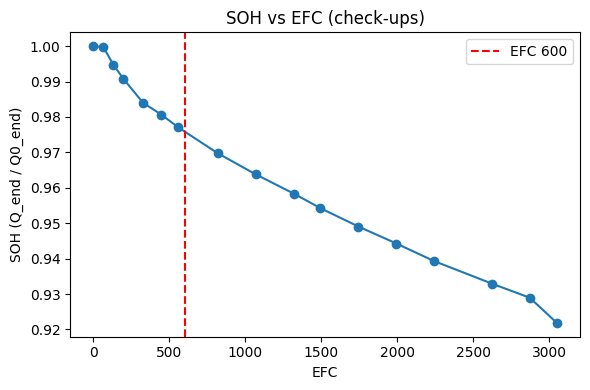

In [23]:
annotator = SOHAtEFCLabelAnnotator(
    target_efc=600.0,
    baseline_efc=0.0,
    max_abs_efc_error=10.0,
    allowed_tags=["ET_T23", "CU", "exCU", "AT_T23"],
    mode="relative",
    include_cv=include_cv,
    cc_current_fraction=cc_current_fraction,
    cv_voltage_window_in_V=cv_voltage_window_in_V,
)

label = annotator.process_cell(cell)
print("SOH@EFC600 label:", float(label))

# Plot SOH vs EFC across check-ups
efc_vals = []
soh_vals = []
for c in cycles:
    efc, tag = cycle_meta(c)
    if tag not in allowed_tags:
        continue
    v, q = get_qv(c)
    if v is None:
        continue
    q_end = float(np.nanmax(q))
    soh = q_end / q0_end
    if efc is not None and np.isfinite(efc):
        efc_vals.append(float(efc))
        soh_vals.append(float(soh))

plt.figure(figsize=(6, 4))
plt.plot(efc_vals, soh_vals, marker="o")
plt.axvline(600, color="red", linestyle="--", label="EFC 600")
plt.title("SOH vs EFC (check-ups)")
plt.xlabel("EFC")
plt.ylabel("SOH (Q_end / Q0_end)")
plt.legend()
plt.tight_layout()

## 7) Temperature curve and segmented stats (illustrative)

,segment,mean_T,max_T,min_T
0,0.00-0.33,27.460424,31.006865,22.690636
1,0.33-0.66,32.638024,33.760583,30.988507
2,0.66-1.00,35.966704,38.790708,33.687150


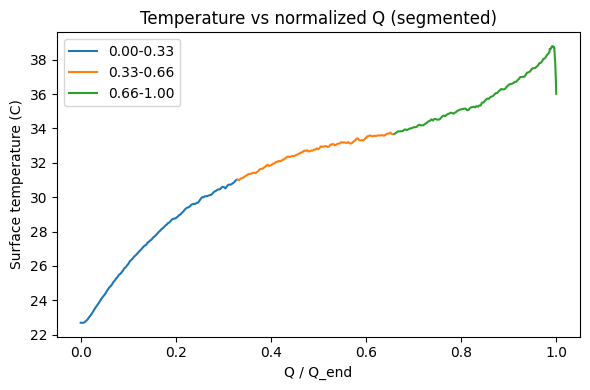

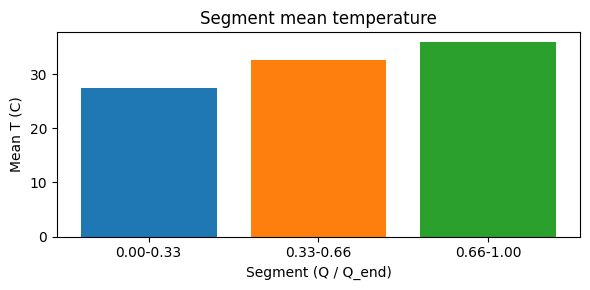

In [24]:
def find_cycle_with_temp(cycles, targets):
    for efc_target in targets:
        c = pick_cycle_by_efc(cycles, efc_target)
        if c is None:
            continue
        t = np.asarray(c.temperature_in_C or [], dtype=float)
        if t.size > 0:
            return c
    for c in cycles:
        t = np.asarray(c.temperature_in_C or [], dtype=float)
        if t.size > 0:
            return c
    return None

temp_cycle = find_cycle_with_temp(cycles, [100.0, 0.0, 200.0, 300.0])
if temp_cycle is None:
    raise RuntimeError("No temperature data found in this cell. Choose another cell.")

v, q = get_qv(temp_cycle)
t = np.asarray(temp_cycle.temperature_in_C or [], dtype=float)
n = min(len(q), len(t))
q = q[:n]
t = t[:n]
q_end = float(np.nanmax(q))
q_norm = q / q_end

segments = [(0.0, 0.33), (0.33, 0.66), (0.66, 1.0)]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for (lo, hi), color in zip(segments, colors):
    mask = (q_norm >= lo) & (q_norm < hi)
    ax.plot(q_norm[mask], t[mask], color=color, label=f"{lo:.2f}-{hi:.2f}")
ax.set_title("Temperature vs normalized Q (segmented)")
ax.set_xlabel("Q / Q_end")
ax.set_ylabel("Surface temperature (C)")
ax.legend()
plt.tight_layout()

stats = []
for lo, hi in segments:
    mask = (q_norm >= lo) & (q_norm < hi)
    if mask.sum() == 0:
        stats.append({"segment": f"{lo:.2f}-{hi:.2f}", "mean_T": np.nan, "max_T": np.nan, "min_T": np.nan})
        continue
    stats.append({
        "segment": f"{lo:.2f}-{hi:.2f}",
        "mean_T": float(np.nanmean(t[mask])),
        "max_T": float(np.nanmax(t[mask])),
        "min_T": float(np.nanmin(t[mask])),
    })

stats_df = pd.DataFrame(stats)
display(stats_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(stats_df["segment"], stats_df["mean_T"], color=colors)
ax.set_title("Segment mean temperature")
ax.set_xlabel("Segment (Q / Q_end)")
ax.set_ylabel("Mean T (C)")
plt.tight_layout()